# Can we read model 1 V-J gene use count matrix PCs to see which V genes matter?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
import seaborn as sns
import joblib
import gc

from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    map_cross_validation_split_strategy_to_default_target_obs_column,
)
from malid.trained_model_wrappers import RepertoireClassifier
from malid import config, helpers, io

In [2]:
def interpret(
    gene_locus: GeneLocus, target_obs_column: TargetObsColumnEnum, fold_id: int
):
    clf_rep = RepertoireClassifier(
        fold_id=fold_id,
        model_name="elasticnet_cv",
        fold_label_train="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        sample_weight_strategy=config.sample_weight_strategy,
    )
    train_count_matrix_columns = joblib.load(
        clf_rep.models_base_dir
        / f"{clf_rep.fold_label_train}_model.{clf_rep.fold_id}.{clf_rep.fold_label_train}.specimen_vj_gene_counts_columns_joblib"
    )

    isotypes = helpers.isotype_groups_kept[gene_locus]
    # # sanity check:
    # isotypes, clf_rep.steps[0][
    #     1
    # ].named_transformers_.keys(), train_count_matrix_columns.keys()

    for isotype in isotypes:
        print(isotype)
        pca_transformer = (
            clf_rep.steps[0][1]
            .named_transformers_[f"log1p-scale-PCA_{isotype}"]
            .steps[-1][1]
        )

        # PCs x VJ pairs
        components_df = pd.DataFrame(
            pca_transformer.components_, columns=train_count_matrix_columns[isotype]
        )
        # display(components_df)

        # most important features for first PC component
        n_top = 10
        # display(components_df.iloc[0].abs().sort_values(ascending=False).head(n=n_top))

        # V genes in there
        print(
            components_df.iloc[0]
            .abs()
            .sort_values(ascending=False)
            .head(n=n_top)
            .index.str.split("|")
            .str[0]
            .unique()
        )

        # second PC coponent, same thing:
        print(
            components_df.iloc[1]
            .abs()
            .sort_values(ascending=False)
            .head(n=n_top)
            .index.str.split("|")
            .str[0]
            .unique()
        )

        print()
        print("*" * 60)
        print()

    adata = io.load_fold_embeddings(
        fold_id=fold_id,
        fold_label="train_smaller",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        # Model 1 does not require the embedding .X, so take the fast path and just load .obs:
        load_obs_only=True,
    )
    featurized = clf_rep.featurize(adata)

    # or use clf_rep._inner[:-1] if we want scaling added:
    pca_transformer = clf_rep.steps[0][1]
    transformed = pd.DataFrame(
        pca_transformer.transform(featurized.X),
        index=featurized.X.index,
        columns=pca_transformer.get_feature_names_out(),
    )
    # Show model 1's top 2 PCs of V/J gene use counts for train fold specimens
    for isotype in helpers.isotype_groups_kept[gene_locus]:
        plot_df = pd.concat(
            [
                transformed[
                    [
                        f"log1p-scale-PCA_{isotype}__pca0",
                        f"log1p-scale-PCA_{isotype}__pca1",
                    ]
                ].rename(
                    columns={
                        f"log1p-scale-PCA_{isotype}__pca0": "PC1",
                        f"log1p-scale-PCA_{isotype}__pca1": "PC2",
                    }
                ),
                featurized.metadata[["disease", "study_name"]],
            ],
            axis=1,
        )
        plot_df["Disease and batch"] = (
            plot_df["disease"].astype(str) + " - " + plot_df["study_name"].astype(str)
        )
        fig, ax = plt.subplots()
        sns.scatterplot(
            data=plot_df, x="PC1", y="PC2", hue="Disease and batch", ax=ax, alpha=0.7
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        sns.despine(ax=ax)
        plt.title(f"{isotype} V-J gene use count PCA")

GeneLocus.BCR, TargetObsColumnEnum.disease, fold -1 (CrossValidationSplitStrategy.in_house_peak_disease_timepoints)
IGHG
Index(['IGHV4-b', 'IGHV1-2', 'IGHV3-23'], dtype='object', name='vgene_jgene')
Index(['IGHV1-18', 'IGHV1-46', 'IGHV3-9', 'IGHV1-24', 'IGHV3-30-3', 'IGHV1-8',
       'IGHV1-69', 'IGHV7-4-1'],
      dtype='object', name='vgene_jgene')

************************************************************

IGHA
Index(['IGHV4-b', 'IGHV4-4', 'IGHV4-39'], dtype='object', name='vgene_jgene')
Index(['IGHV4-34', 'IGHV1-24', 'IGHV1-2', 'IGHV3-23', 'IGHV3-7', 'IGHV1-46',
       'IGHV1-8'],
      dtype='object', name='vgene_jgene')

************************************************************

IGHD-M
Index(['IGHV4-39', 'IGHV3-48', 'IGHV1-3', 'IGHV4-b', 'IGHV1-46', 'IGHV4-61',
       'IGHV1-18'],
      dtype='object', name='vgene_jgene')
Index(['IGHV5-51', 'IGHV3-49', 'IGHV3-21', 'IGHV3-48', 'IGHV3-23', 'IGHV3-15',
       'IGHV1-69'],
      dtype='object', name='vgene_jgene')

************


GeneLocus.TCR, TargetObsColumnEnum.disease, fold -1 (CrossValidationSplitStrategy.in_house_peak_disease_timepoints)
TCRB
Index(['TRBV18', 'TRBV10-2', 'TRBV20-1', 'TRBV25-1'], dtype='object', name='vgene_jgene')
Index(['TRBV30', 'TRBV5-4'], dtype='object', name='vgene_jgene')

************************************************************



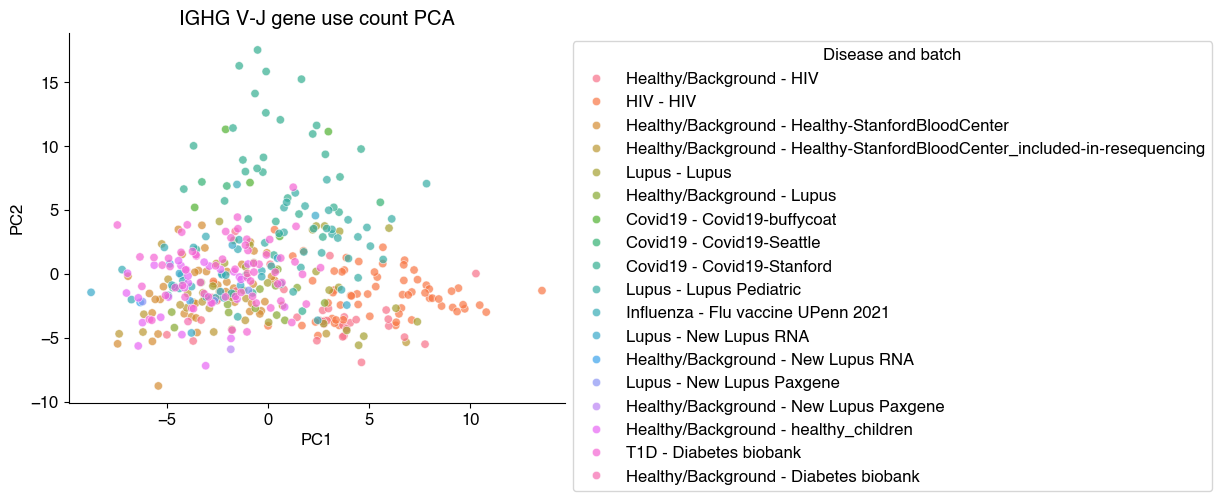

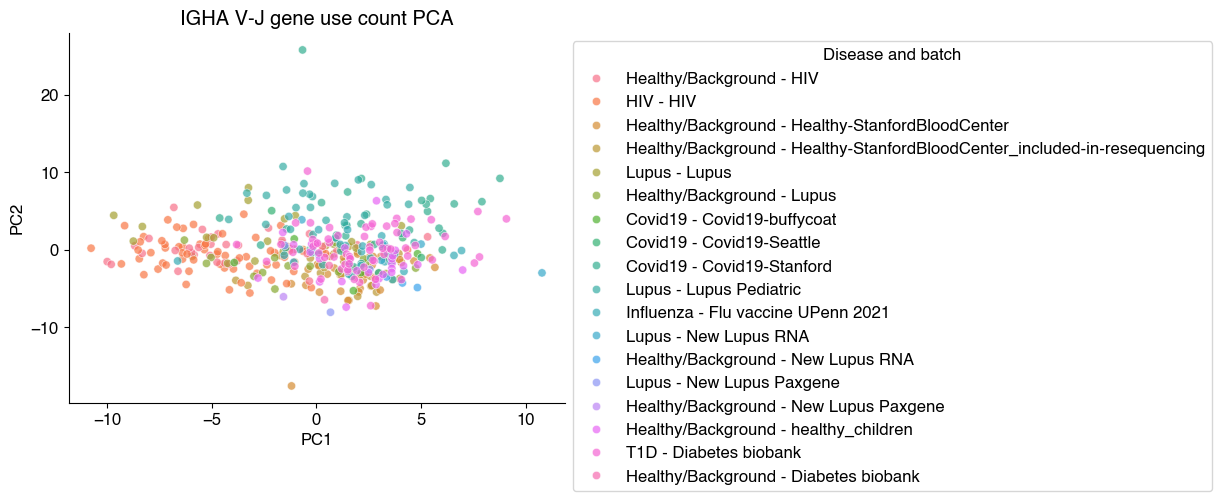

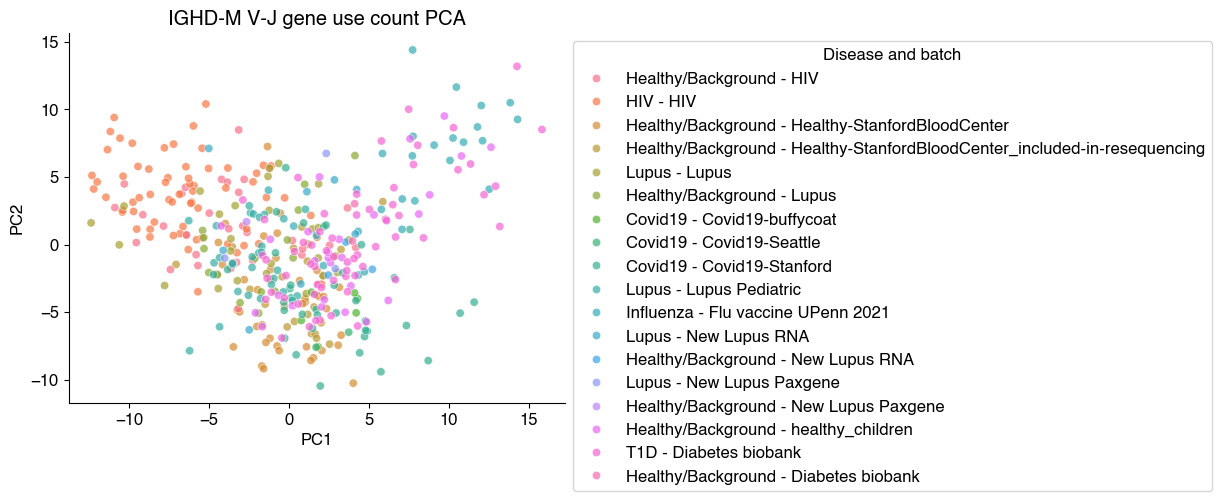

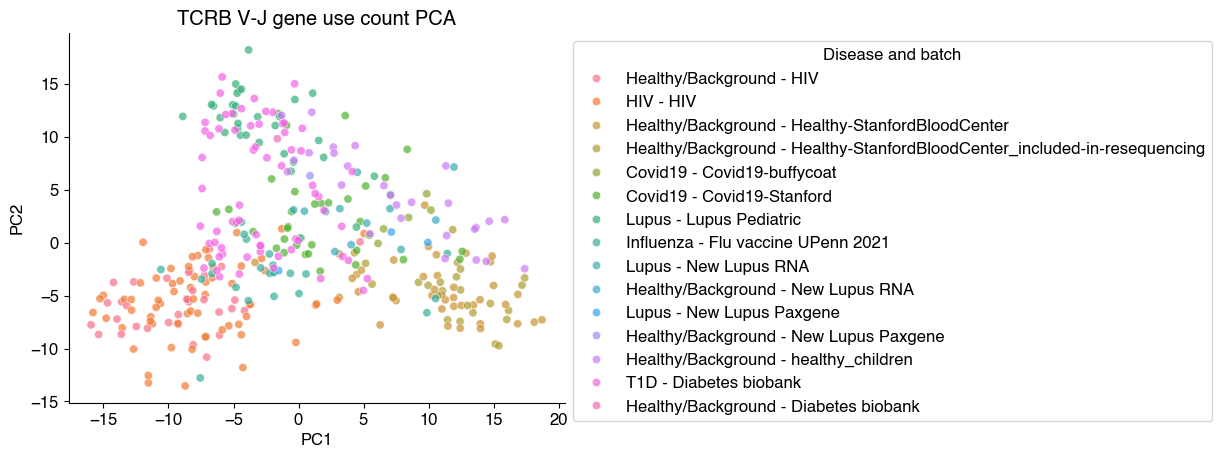

In [3]:
# Choose fold:
# Prefer global fold (fold -1), unless the cross validation split strategy is restricted to a single fold.
fold_id = 0 if config.cross_validation_split_strategy.value.is_single_fold_only else -1


# Choose classification target:
target_obs_column = map_cross_validation_split_strategy_to_default_target_obs_column[
    config.cross_validation_split_strategy
]

for gene_locus in config.gene_loci_used:
    print(
        f"{gene_locus}, {target_obs_column}, fold {fold_id} ({config.cross_validation_split_strategy})"
    )
    interpret(
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        fold_id=fold_id,
    )
    io.clear_cached_fold_embeddings()
    gc.collect()
    print()